Loading Data Using Pandas

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_excel("../Data/Data_Train.xlsx")

In [39]:
df.dropna(inplace=True)

In [40]:
data = df.copy()

In [41]:
def change_into_Datetime(col):
    data[col] = pd.to_datetime(data[col])

In [42]:
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [43]:
for feature in ['Dep_Time', 'Arrival_Time' , 'Date_of_Journey']:
    change_into_Datetime(feature)

In [44]:
data["Journey_day"] = data['Date_of_Journey'].dt.day
data["Journey_month"] = data['Date_of_Journey'].dt.month
data["Journey_year"] = data['Date_of_Journey'].dt.year

In [45]:
def extract_hour_min(df , col):
    df[col+"_hour"] = df[col].dt.hour
    df[col+"_minute"] = df[col].dt.minute
    return df.head(3)

In [46]:
extract_hour_min(data , "Dep_Time")
extract_hour_min(data , "Arrival_Time")

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-09-12 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2023-09-12 05:50:00,2023-09-12 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2023-09-12 09:25:00,2023-06-10 04:25:00,19h,2 stops,No info,13882,6,9,2019,9,25,4,25


In [47]:
cols_to_drop = ['Arrival_Time' , "Dep_Time"]

data.drop(cols_to_drop , axis=1 , inplace=True )

In [48]:
def preprocess_duration(x):
    if 'h' not in x:
        x = '0h' + ' ' + x
    elif 'm' not in x:
        x = x + ' ' +'0m'

    return x

In [49]:
data['Duration'] = data['Duration'].apply(preprocess_duration)

In [50]:
data['Duration_hours'] = data['Duration'].apply(lambda x : int(x.split(' ')[0][0:-1]))
data['Duration_mins'] = data['Duration'].apply(lambda x : int(x.split(' ')[1][0:-1]))

In [51]:
data['Duration_total_mins'] = data['Duration'].str.replace('h' ,"*60").str.replace(' ' , '+').str.replace('m' , "*1").apply(eval)

In [52]:
for sub_category in data['Source'].unique():
    data['Source_'+sub_category] = data['Source'].apply(lambda x : 1 if x==sub_category else 0)

In [53]:
airlines = data.groupby(['Airline'])['Price'].mean().sort_values().index

In [54]:
dict_airlines = {key:index for index , key in enumerate(airlines , 0)}

In [55]:
dict_airlines

{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Vistara Premium economy': 6,
 'Air India': 7,
 'Multiple carriers': 8,
 'Multiple carriers Premium economy': 9,
 'Jet Airways': 10,
 'Jet Airways Business': 11}

In [56]:
data['Airline'] = data['Airline'].map(dict_airlines)

In [57]:
data['Destination'].replace('New Delhi' , 'Delhi' , inplace=True)

In [58]:
dest = data.groupby(['Destination'])['Price'].mean().sort_values().index
dict_dest = {key:index for index , key in enumerate(dest , 0)}

In [59]:
data['Destination'] = data['Destination'].map(dict_dest)

In [60]:
stop = {'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

In [61]:
data['Total_Stops'] = data['Total_Stops'].map(stop)

In [62]:
data.drop(columns=['Date_of_Journey' , 'Additional_Info' , 'Duration_total_mins' , 'Source' , 'Journey_year'] , axis=1 , inplace=True)

In [63]:
data.drop(columns=['Route'] , axis=1 , inplace=True)


In [64]:
data.drop(columns=['Duration'] , axis=1 , inplace=True)


In [65]:
X = data.drop(columns=['Price'])
y = data['Price']


In [66]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
ml_model = RandomForestRegressor()

In [69]:
ml_model.fit(x_train,y_train)

RandomForestRegressor()

In [70]:
y_pred = ml_model.predict(x_test)

In [71]:
from sklearn import metrics

In [72]:
metrics.r2_score(y_test,y_pred)

0.794806690410447

In [73]:
import pickle

In [74]:
file = open("./ml_models/rf_model_79.pkl","wb")

In [75]:
pickle.dump(ml_model,file)

In [76]:
model = open("./ml_models/rf_model_79.pkl","rb")
ml_model_rf = pickle.load(model)

In [77]:
y_pred_file = ml_model_rf.predict(x_test)

In [78]:
metrics.r2_score(y_test,y_pred_file)

0.794806690410447

In [79]:

def mape(y_true , y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean( np.abs( ( y_true - y_pred ) / y_true ) ) * 100

In [80]:
mape(y_test, y_pred)

13.1357520365534

In [81]:
def predict(ml_model):
    model = ml_model.fit(x_train, y_train)
    print(f"Training Score : {model.score(x_train,y_train)}")
    y_prediction = model.predict(x_test)
    print(f"Predictions are : {y_prediction} ")
    print("\n")
    print(f"R2_Score : { metrics.r2_score( y_test , y_prediction ) } ")
    print(f"MAE : { metrics.mean_absolute_error( y_test , y_prediction ) } ")
    print(f"MSE : { metrics.mean_squared_error( y_test , y_prediction ) } ")
    print(f"RMSE : { np.sqrt(metrics.mean_squared_error( y_test , y_prediction ) ) } ")
    print(f"MAPE : { mape( y_test , y_prediction ) } ")
    sns.distplot(y_test - y_prediction)

Training Score : 0.9707490055980877
Predictions are : [16840.  6976.  9187. ...  3419.  5797.  6818.] 


R2_Score : 0.6968685922879212 
MAE : 1345.6709409709222 
MSE : 6248455.715469549 
RMSE : 2499.691124013035 
MAPE : 14.821953317743757 


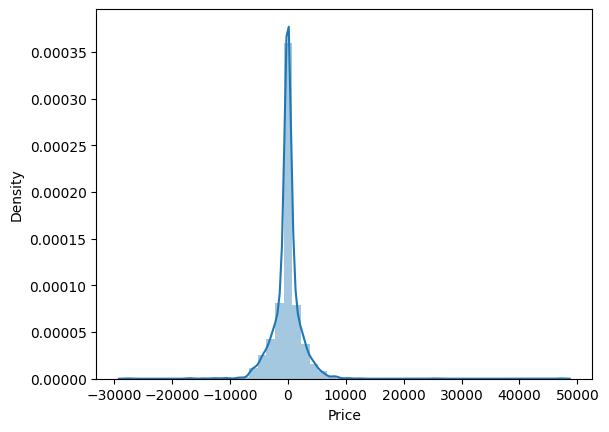

In [83]:
from sklearn.tree import  DecisionTreeRegressor
predict((DecisionTreeRegressor()))

In [84]:
from sklearn.model_selection import RandomizedSearchCV


In [85]:
reg_rf = RandomForestRegressor()

In [86]:
"""
(
    n_estimators: Int = 100,
    *, 
    criterion: Literal['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] = "squared_error", 
    max_depth: Int | None = None, 
    min_samples_split: float | int = 2, 
    min_samples_leaf: float | int = 1, 
    min_weight_fraction_leaf: Float = 0, 
    max_features: float | int | Literal['sqrt', 'log2'] = 1, 
    max_leaf_nodes: Int | None = None, 
    min_impurity_decrease: Float = 0, 
    bootstrap: bool = True, 
    oob_score: bool = False, 
    n_jobs: Int | None = None, 
    random_state: Int | RandomState | None = None, 
    verbose: Int = 0, 
    warm_start: bool = False, 
    ccp_alpha: float = 0, 
    max_samples: float | int | None = None
    ) -> None

"""

'\n(\n    n_estimators: Int = 100,\n    *, \n    criterion: Literal[\'squared_error\', \'absolute_error\', \'friedman_mse\', \'poisson\'] = "squared_error", \n    max_depth: Int | None = None, \n    min_samples_split: float | int = 2, \n    min_samples_leaf: float | int = 1, \n    min_weight_fraction_leaf: Float = 0, \n    max_features: float | int | Literal[\'sqrt\', \'log2\'] = 1, \n    max_leaf_nodes: Int | None = None, \n    min_impurity_decrease: Float = 0, \n    bootstrap: bool = True, \n    oob_score: bool = False, \n    n_jobs: Int | None = None, \n    random_state: Int | RandomState | None = None, \n    verbose: Int = 0, \n    warm_start: bool = False, \n    ccp_alpha: float = 0, \n    max_samples: float | int | None = None\n    ) -> None\n\n'

In [99]:
n_estimators = np.linspace(start = 100 , stop = 1000 , num= 11 , dtype= "int")

In [101]:
max_features = ['auto','sqrt']

In [102]:
max_depth = [2,3,4,5]

In [103]:
min_samples_split = [5,10,15,100]

In [104]:
random_grid = {
    "n_estimators":n_estimators,
    "max_features" : max_features,
    "max_depth":max_depth,
    "min_samples_split":min_samples_split
}

In [105]:
rf_random = RandomizedSearchCV(estimator = reg_rf , param_distributions=random_grid, cv=3, n_jobs=-1)

In [ ]:
rf_random.fit(x_train , y_train)

In [107]:
rf_random.best_params_

{'n_estimators': 820,
 'min_samples_split': 5,
 'max_features': 'auto',
 'max_depth': 5}

In [108]:
rf_random.best_score_

0.7200438478559521